In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
path = 'Resources/Data_ElectricPe.xlsx'
data = pd.read_excel(path)
data.head()

,StationID,Station_Name,Station_Type,Station_Category,Station_Access,ChargerID,Ping_Date,hour0,hour1,hour2,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-25,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-26,True,True,True,...,False,False,False,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-27,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-28,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0124a793-6b67-4690-8348-54666a807fe7,SRI VARU CELESTIAL APARTMENT,RESIDENTIAL,SMALL,PUBLIC,WA000822LAC1S009464-1,2023-11-29,True,True,True,...,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
# Drop rows with missing values
data_cleaned = data.dropna()
data_cleaned['DayOfWeek'] = data_cleaned['Ping_Date'].dt.day_name()

In [4]:
# 1. Calculate Daily Average Uptime and Additional Features
data_cleaned['Daily_Average_Uptime'] = data_cleaned[[f'hour{i}' for i in range(24)]].mean(axis=1)
data_cleaned['Peak_Hour'] = data_cleaned[[f'hour{i}' for i in range(24)]].idxmax(axis=1).str.extract(r'(\d+)').astype(int)
data_cleaned['Hourly_Uptime_StdDev'] = data_cleaned[[f'hour{i}' for i in range(24)]].std(axis=1)

# Optional: Drop individual hour columns if unnecessary
data_cleaned.drop([f'hour{i}' for i in range(24)], axis=1, inplace=True)

# 2. Convert boolean columns to integers
bool_columns = data_cleaned.select_dtypes(include=['bool']).columns
data_cleaned[bool_columns] = data_cleaned[bool_columns].astype(int)

# 3. Encode Categorical Columns
# a) Label encode ordinal columns
label_encoder = LabelEncoder()
ordinal_columns = ['DayOfWeek']  # Add other ordinal columns if applicable
for col in ordinal_columns:
    data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col])

# b) One-hot encode non-ordinal categorical columns
categorical_columns = ['Station_Access', 'Station_Category']
data_cleaned = pd.get_dummies(data_cleaned, columns=categorical_columns)

# 4. Encode StationID/ChargerID
data_cleaned['StationID'] = label_encoder.fit_transform(data_cleaned['StationID'])
data_cleaned['ChargerID'] = label_encoder.fit_transform(data_cleaned['ChargerID'])

# 5. Scale Numerical Features
numerical_columns = ['Daily_Average_Uptime', 'Hourly_Uptime_StdDev', 'Peak_Hour']
scaler = MinMaxScaler()
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

# 6. Drop Irrelevant Columns
irrelevant_columns = ['Ping_Date', 'Station_Name']  # Adjust as needed
data_cleaned = data_cleaned.drop(columns=irrelevant_columns)

# 7. Final Check
print(data_cleaned.dtypes)
# print(data_cleaned.isnull().sum())
print(data_cleaned.head())

StationID                                 int64
Station_Type                             object
ChargerID                                 int64
DayOfWeek                                 int64
Daily_Average_Uptime                    float64
Peak_Hour                               float64
Hourly_Uptime_StdDev                    float64
Station_Access_PRIVATE                     bool
Station_Access_PUBLIC                      bool
Station_Access_RESTRICTED                  bool
Station_Category_APARTMENT                 bool
Station_Category_DIY                       bool
Station_Category_INDEPENDENT               bool
Station_Category_INDEPENDENT_HOUSE         bool
Station_Category_INDIVIDUAL_BUILDING       bool
Station_Category_L                         bool
Station_Category_LARGE                     bool
Station_Category_MEDIUM                    bool
Station_Category_OTHERS                    bool
Station_Category_RESIDENTIAL               bool
Station_Category_SMALL                  

In [5]:
# Add rolling averages
data_cleaned['Rolling_Mean_3'] = data_cleaned['Daily_Average_Uptime'].rolling(3).mean()
data_cleaned['Rolling_Mean_7'] = data_cleaned['Daily_Average_Uptime'].rolling(7).mean()

# Add more lag features
data_cleaned['Lag_2'] = data_cleaned['Daily_Average_Uptime'].shift(2)
data_cleaned['Lag_3'] = data_cleaned['Daily_Average_Uptime'].shift(3)

# Impute nulls with 0s
data_cleaned.fillna(0, inplace=True)

In [6]:
# Select features and target
features = [col for col in data_cleaned.columns if col not in ['Daily_Average_Uptime', 'Ping_Date', 'Station_Type']]
X = data_cleaned[features]
y = data_cleaned['Daily_Average_Uptime']

In [7]:
print(X.columns)

Index(['StationID', 'ChargerID', 'DayOfWeek', 'Peak_Hour',
       'Hourly_Uptime_StdDev', 'Station_Access_PRIVATE',
       'Station_Access_PUBLIC', 'Station_Access_RESTRICTED',
       'Station_Category_APARTMENT', 'Station_Category_DIY',
       'Station_Category_INDEPENDENT', 'Station_Category_INDEPENDENT_HOUSE',
       'Station_Category_INDIVIDUAL_BUILDING', 'Station_Category_L',
       'Station_Category_LARGE', 'Station_Category_MEDIUM',
       'Station_Category_OTHERS', 'Station_Category_RESIDENTIAL',
       'Station_Category_SMALL', 'Rolling_Mean_3', 'Rolling_Mean_7', 'Lag_2',
       'Lag_3'],
      dtype='object')


In [17]:
df = data_cleaned.copy()
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)
df.drop(["Station_Type"], axis=1, inplace=True)
correlation_matrix = df.corr()

In [18]:
print(correlation_matrix['Daily_Average_Uptime'].sort_values(ascending=False))

Daily_Average_Uptime                    1.000000
Rolling_Mean_3                          0.893082
Rolling_Mean_7                          0.683447
Lag_2                                   0.641323
Lag_3                                   0.500925
StationID                               0.034306
Station_Category_LARGE                  0.032570
Station_Access_RESTRICTED               0.023916
Station_Access_PRIVATE                  0.019692
Station_Category_APARTMENT              0.018450
Station_Category_DIY                    0.012014
Station_Category_RESIDENTIAL            0.011391
Station_Category_INDEPENDENT            0.008494
Station_Category_INDIVIDUAL_BUILDING    0.008494
Station_Category_OTHERS                 0.008292
ChargerID                              -0.005127
DayOfWeek                              -0.005228
Station_Category_SMALL                 -0.010371
Station_Category_MEDIUM                -0.021316
Station_Category_INDEPENDENT_HOUSE     -0.025142
Station_Access_PUBLI

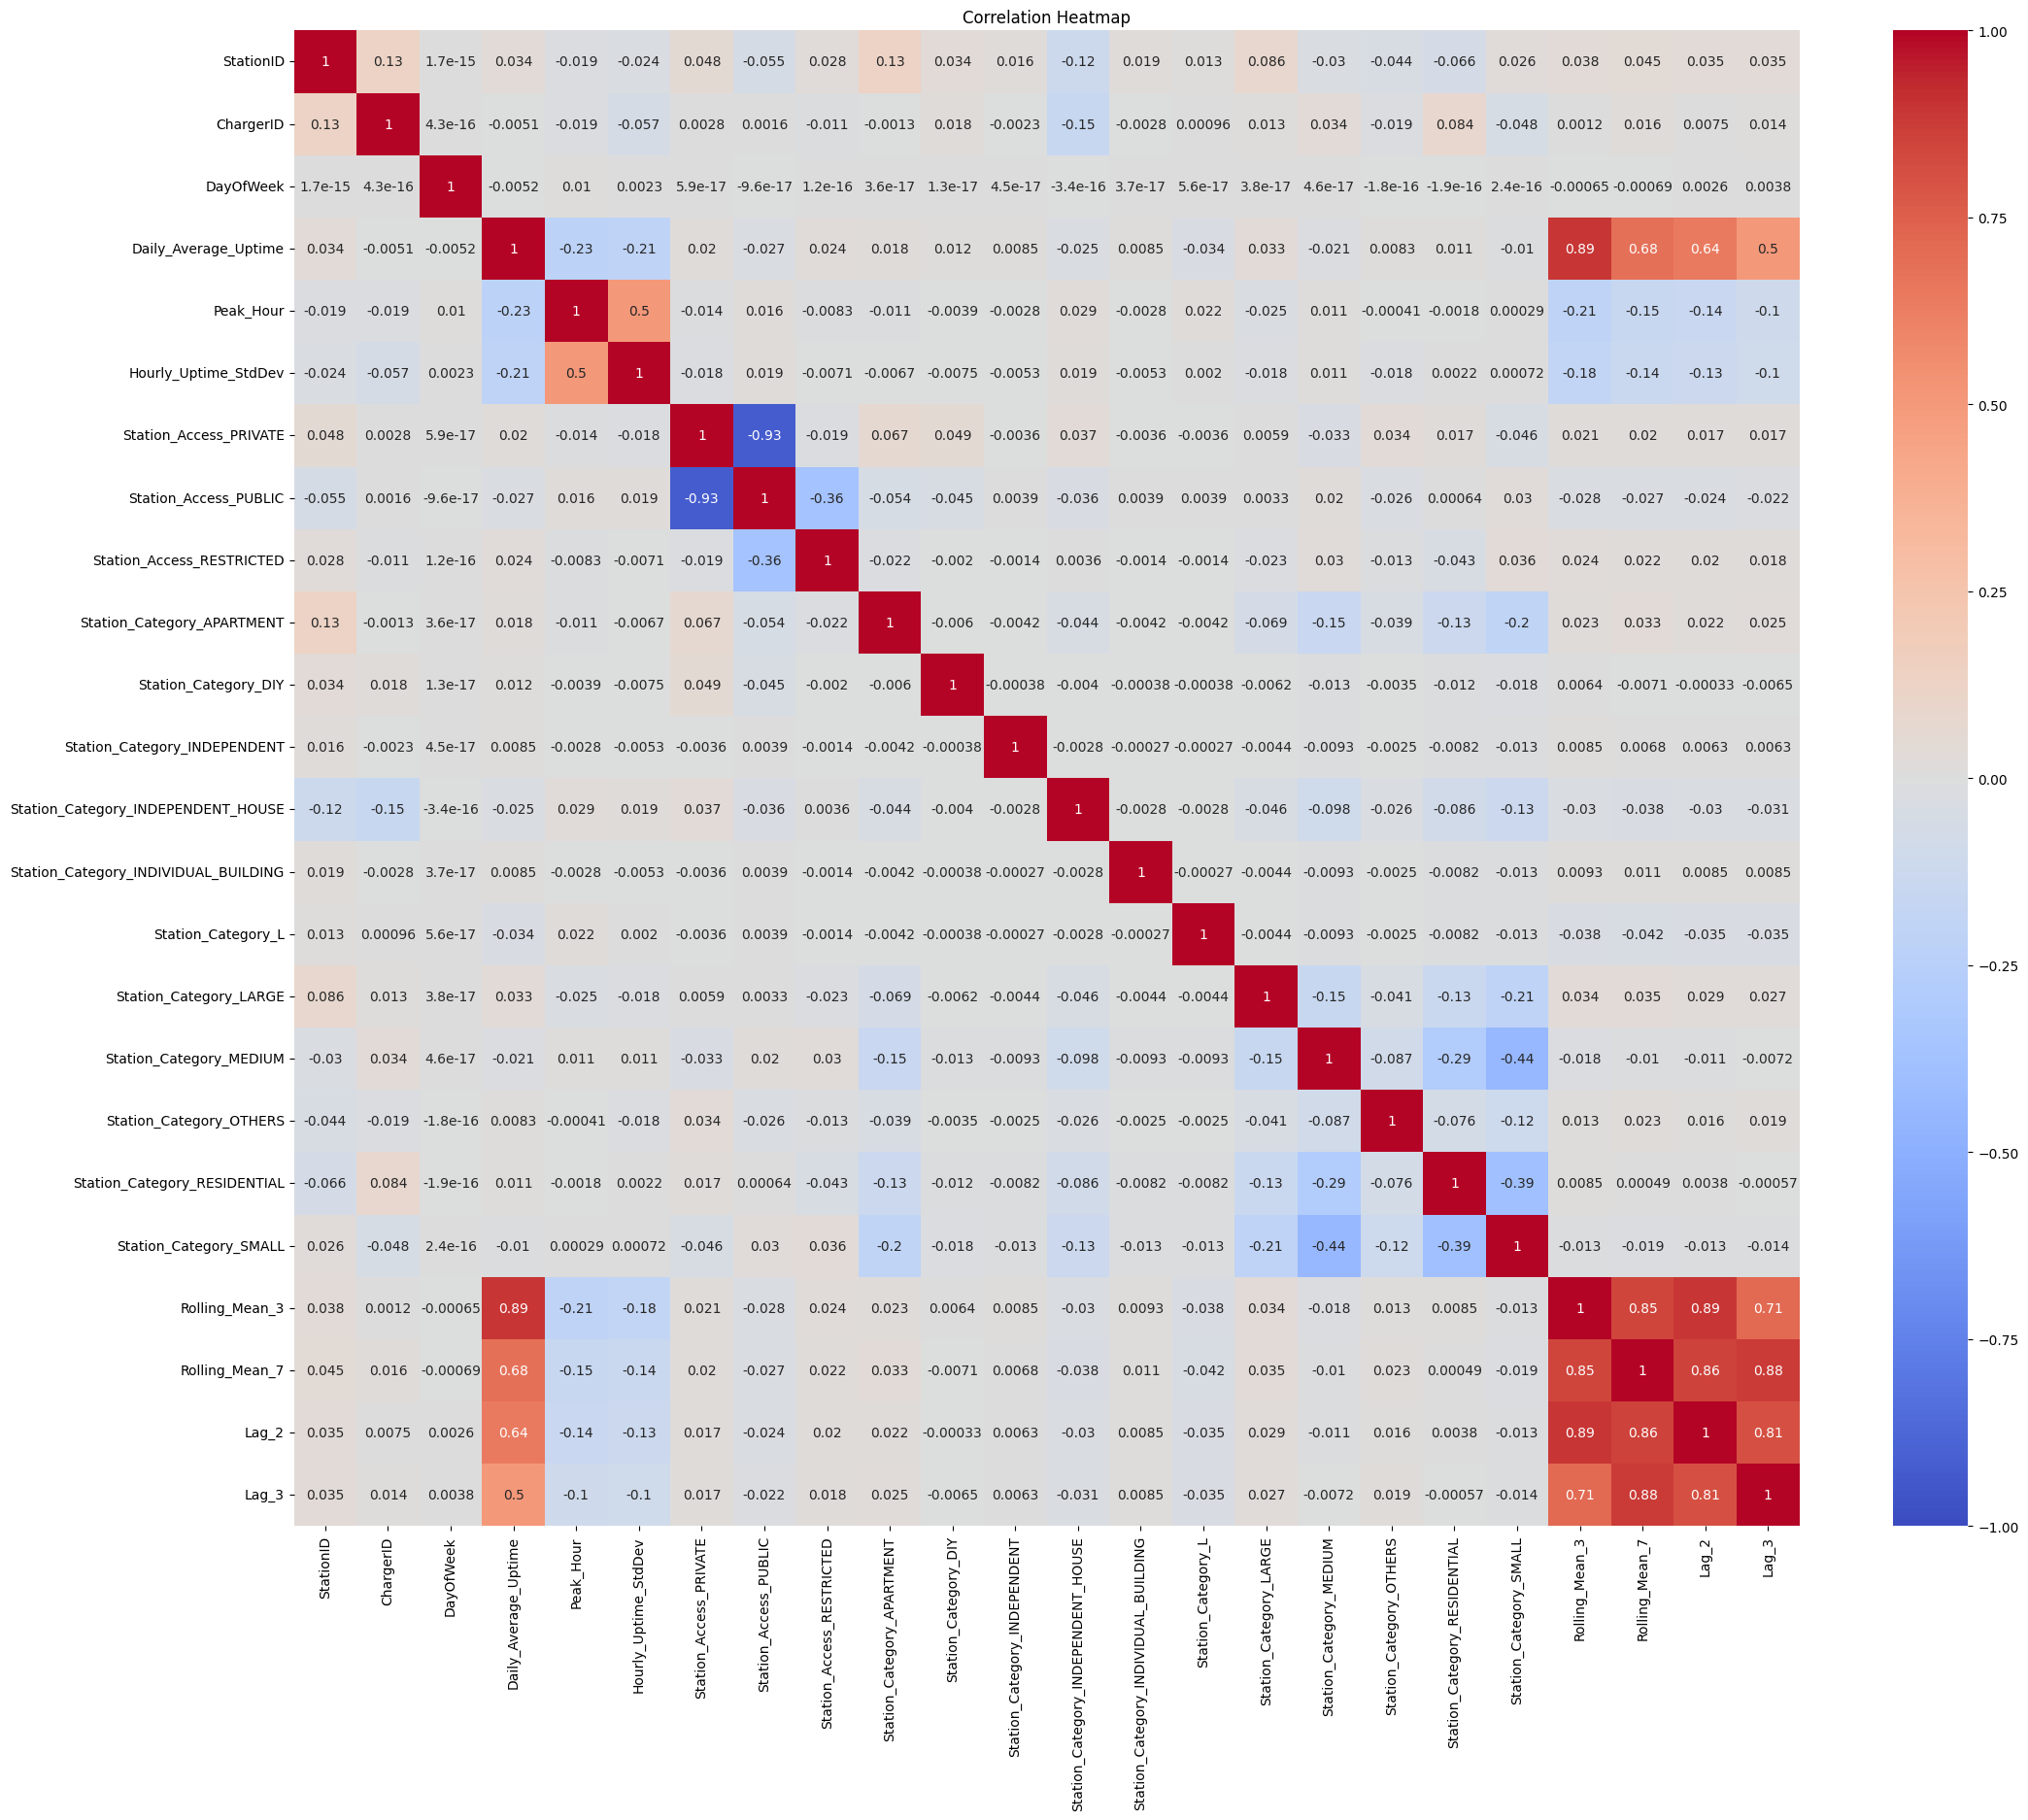

In [25]:
# Create the heatmap using seaborn
plt.figure(figsize=(25, 20))  # Adjust width and height as needed

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1) 
# Customize the plot (optional)
plt.title('Correlation Heatmap')
plt.show()


In [8]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def run_and_evaluate_models(X, y):
    """
    Utility function to train multiple models, evaluate their performance,
    and predict the next day's uptime using the last day's uptime.

    Parameters:
    - X: Features (Pandas DataFrame)
    - y: Target variable (Pandas Series)

    Returns:
    - results: DataFrame summarizing RMSE of each model
    - predictions: Dictionary with model names and their next-day uptime prediction
    """
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    # Define models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
        'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        'CatBoost': CatBoostRegressor(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42),
        'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    }
    
    results = []
    predictions = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        try:
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            
            # Predict the next day's uptime using the last day's features
            last_day_features = X.iloc[-1].values.reshape(1, -1)
            next_day_prediction = model.predict(last_day_features)[0]
            
            # Append results
            results.append({'Model': model_name, 'RMSE': rmse})
            predictions[model_name] = next_day_prediction
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            results.append({'Model': model_name, 'RMSE': None})
            predictions[model_name] = None
    
    # Create a DataFrame for results
    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    return results_df, predictions

In [10]:
# Run the utility function
results_df, predictions = run_and_evaluate_models(X, y)

# Display results
print("Model Performance:")
print(results_df)

print("\nNext Day Uptime Predictions:")
for model, prediction in predictions.items():
    print(f"{model}: {prediction}")

Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 15020, number of used features: 19
[LightGBM] [Info] Start training from score 0.791692
Training CatBoost...
Training SVR...
Model Performance:
           Model      RMSE
0  Random Forest  0.044239
2       LightGBM  0.045708
3       CatBoost  0.048534
1        XGBoost  0.049792
4            SVR  0.347333

Next Day Uptime Predictions:
Random Forest: 1.0
XGBoost: 1.0015145540237427
LightGBM: 1.0040841043129283
CatBoost: 1.0005167842484766
SVR: 0.7334655868890333
